In [58]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import pytesseract
import os
import imutils
from PIL import Image
from pytesseract import Output
from matplotlib import pyplot as plt


In [222]:
img_location = "./data/images_data/1010(2023-05-29T12_17_09).jpg"

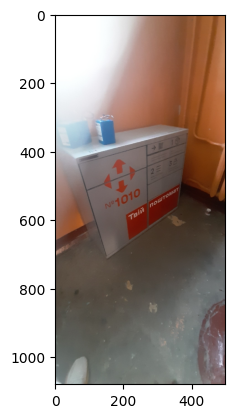

In [223]:
img = cv2.imread(img_location)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [224]:
box_id = img_location.split("/")[-1].split("(")[0]
print(img_location)
print(box_id)

./data/images_data/1010(2023-05-29T12_17_09).jpg
1010


In [225]:
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
lower_blue = np.array([110,50,50])
upper_blue = np.array([130,255,255])
# Threshold the HSV image to get only blue colors
mask = cv2.inRange(hsv, lower_blue, upper_blue)

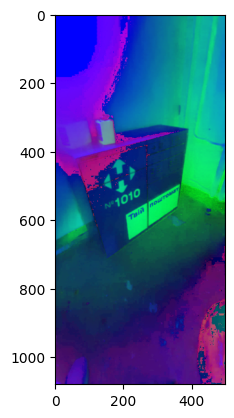

In [226]:
plt.imshow(hsv)
plt.show()

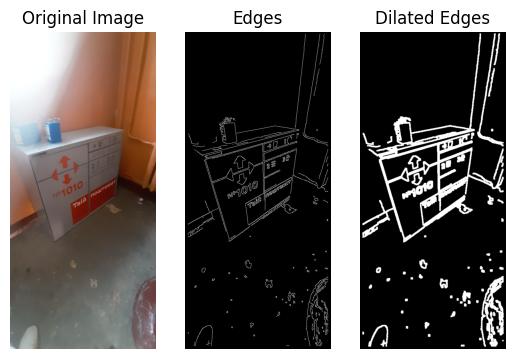

In [240]:
# Load the image 
image = cv2.imread(img_location) 
 
# Convert to grayscale 
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
 
# Blur the image 
blurred = cv2.GaussianBlur(gray, (5, 5), 0) 

# Detect edges 
edges = cv2.Canny(blurred, 20, 50) 

kernel = np.ones((5, 5), np.uint8) 

img_dilation = cv2.dilate(edges, kernel, iterations=1) 
#plt.imshow(img_dilation)


keypoints = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 
contours = imutils.grab_contours(keypoints)
contours = sorted(contours,key=cv2.contourArea,reverse=True)
new_image = None
location = None
mask = np.zeros(gray.shape,np.uint8)

for contour in contours:
    approx = cv2.approxPolyDP(contour, 0.02 * cv2.arcLength(contour, True),True)
    if len(approx)<=4:
        location=approx
        new_image = cv2.drawContours(mask,[location],0,255,-1)
        new_image = cv2.bitwise_and(img,img,mask=mask)

#plt.imshow(cv2.cvtColor(new_image,cv2.COLOR_BGR2RGB))

# # Find contours 
# contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 
 
# # Filter contours 
# rects = [] 
# for contour in contours: 
#     # Approximate the contour to a polygon 
#     polygon = cv2.approxPolyDP(contour, 0.01 * cv2.arcLength(contour, True), True) 
     
#     # Check if the polygon has 4 sides and the aspect ratio is close to 1 
#     if len(polygon) == 4 and abs(1 - cv2.contourArea(polygon) / (cv2.boundingRect(polygon)[2] * cv2.boundingRect(polygon)[3])) < 1: 
#         rects.append(polygon) 
 
# # Draw rectangles 
# for rect in rects: 
#     cv2.drawContours(image, [rect], 0, (0, 255, 0), 2) 
 
# # Show the result 
# #plt.imshow(image)
# plt.show()

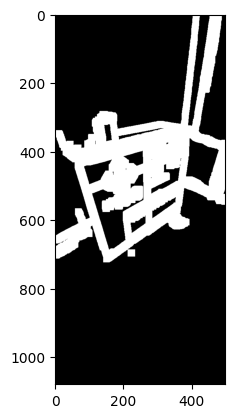

In [235]:
# Apply morphological dilation to connect nearby regions
kernel = np.ones((15, 15), np.uint8)  # Adjust the kernel size as needed
connected_mask = cv2.dilate(img_dilation.astype(np.uint8), kernel, iterations=1)

# Use connected components to label objects in the connected mask
_, labels, stats, _ = cv2.connectedComponentsWithStats(connected_mask)

# Find the label of the largest connected component
largest_component_label = np.argmax(stats[1:, cv2.CC_STAT_AREA]) + 1

# Create a binary mask for the largest connected component
largest_component_mask = (labels == largest_component_label).astype(np.uint8)

# Display the result binary mask
plt.imshow(largest_component_mask, cmap='gray')

In [200]:
# Load the image 
image = cv2.imread(img_location) 
 
# Convert to grayscale 
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
 
# Blur the image 
blurred = cv2.GaussianBlur(gray, (5, 5), 0) 


# Detect edges 
edges = cv2.Canny(blurred, 20, 70) 

kernel = np.ones((5, 5), np.uint8) 

img_dilation = cv2.dilate(edges, kernel, iterations=1) 
plt.imsave("./edges.jpg",img_dilation)


In [189]:
recs = os.system(f'python ./models/lcnn/demo.py -d 0 ./models/lcnn/config/wireframe.yaml "C:/Users/Tymof/OneDrive/Desktop/education/Practice/Meduzzen_Intership/ML_NovaPoshta_CV/models/lcnn/190418-201834-f8934c6-lr4d10-312k.pth" "C:/Users/Tymof/OneDrive/Desktop/education/Practice/Meduzzen_Intership/ML_NovaPoshta_CV/edges.jpg"')

In [177]:
def resize(img, width=None, height=None, interpolation = cv2.INTER_AREA):
    global ratio
    w, h, _ = img.shape

    if width is None and height is None:
        return img
    elif width is None:
        ratio = height/h
        width = int(w*ratio)
        print(width)
        resized = cv2.resize(img, (height, width), interpolation)
        return resized
    else:
        ratio = width/w
        height = int(h*ratio)
        print(height)
        resized = cv2.resize(img, (height, width), interpolation)
        return resized

In [180]:
# define variable for resize tratio
ratio = 1

def for_point_warp(cnt, orig):
    # we need to determine
    # the top-left, top-right, bottom-right, and bottom-left
    # points so that we can later warp the image -- we'll start
    # by reshaping our contour to be our finals and initializing
    # our output rectangle in top-left, top-right, bottom-right,
    # and bottom-left order
    pts = cnt.reshape(4, 2)
    rect = np.zeros((4, 2), dtype = "float32")

    # summing the (x, y) coordinates together by specifying axis=1
    # the top-left point has the smallest sum whereas the
    # bottom-right has the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # compute the difference between the points -- the top-right
    # will have the minumum difference and the bottom-left will
    # have the maximum difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    # Notice how our points are now stored in an imposed order: 
    # top-left, top-right, bottom-right, and bottom-left. 
    # Keeping a consistent order is important when we apply our perspective transformation

    # now that we have our rectangle of points, let's compute
    # the width of our new image
    (tl, tr, br, bl) = rect
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))

    # ...and now for the height of our new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))

    # take the maximum of the width and height values to reach
    # our final dimensions
    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))

    # construct our destination points which will be used to
    # map the screen to a top-down, "birds eye" view
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")

    # calculate the perspective transform matrix and warp
    # the perspective to grab the screen
    M = cv2.getPerspectiveTransform(rect, dst)
    warp = cv2.warpPerspective(orig, M, (maxWidth, maxHeight))
    return warp

1303


ValueError: array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8) is not a valid value for cmap; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

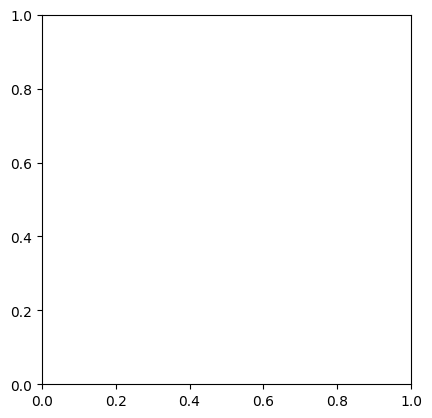

In [184]:
#load an image
flat_object = cv2.imread(img_location)
#resize the image
flat_object_resized = resize(flat_object, height=600)
#make a copy
flat_object_resized_copy = flat_object_resized.copy()
#convert to HSV color scheme
flat_object_resized_hsv = cv2.cvtColor(flat_object_resized_copy, cv2.COLOR_BGR2HSV)
# split HSV to three chanels
hue, saturation, value = cv2.split(flat_object_resized_hsv)
# threshold to find the contour
retval, thresholded = cv2.threshold(saturation, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
# morphological operations
thresholded_open = cv2.morphologyEx(thresholded, cv2.MORPH_OPEN, (7,7))
thresholded_close = cv2.morphologyEx(thresholded_open, cv2.MORPH_CLOSE, (7,7))
# find edges
thresholded_edge = cv2.Canny(thresholded_close, 15, 150)
plt.imshow("Warped ROI", thresholded_edge)

# The cv2.findContours method is destructive (meaning it manipulates the image you pass in) 
# so if you plan on using that image again later, be sure to clone it. 
cnts = cv2.findContours(thresholded_edge.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
# keep only 10 the largest ones
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:10]
# the contour that we seek for
our_cnt = None
# loop over our 10 largest contours in the query image
for c in cnts:
    # approximate the contour
    # These methods are used to approximate the polygonal curves of a contour. 
    # In order to approximate a contour, you need to supply your level of approximation precision. 
    # In this case, we use 2% of the perimeter of the contour. The precision is an important value to consider. 
    # If you intend on applying this code to your own projects, you’ll likely have to play around with the precision value.
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    # if our approximated contour has four points, then
    # we can assume that we have found our screen
    if len(approx) >= 4:
        our_cnt = approx
        break

# draw a contour
#cv2.drawContours(flat_object_resized_copy, [our_cnt], -1, (0,255,0), 3)
#plt.imshow("Warped ROI", flat_object_resized_copy)


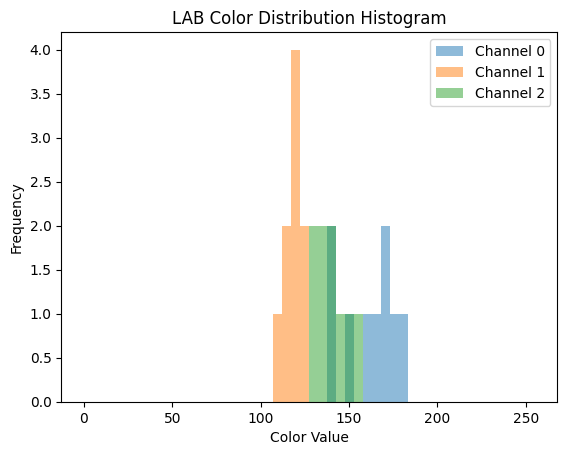

(-0.5, 809.5, 1079.5, -0.5)

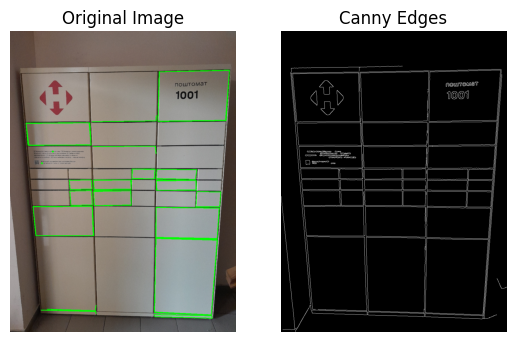

In [48]:
# Convert to LAB color space
lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
colors=[]
for rect in rects:
    # Get the bounding box coordinates of the rectangle
    x, y, w, h = cv2.boundingRect(rect)

    # Exclude the green rectangles
    if np.array_equal(image[y, x], [0, 255, 0]):
        continue

    # Crop the region of interest (ROI) from the LAB image
    roi_lab = lab_image[y:y + h, x:x + w]

    # Calculate the mean color values in the LAB space
    mean_color_lab = cv2.mean(roi_lab)[:3]  # Extract LAB color values
    colors.append(mean_color_lab)

# Convert the list of LAB color values to a NumPy array
colors_array_lab = np.array(colors)

# Ensure colors_array_lab is 2D (in case there's only one rectangle)
if colors_array_lab.ndim == 1:
    colors_array_lab = colors_array_lab.reshape(-1, 1)
# Display histogram for each LAB channel
for i in range(3):  # Loop over LAB channels
    plt.hist(colors_array_lab[:, i], bins=50, range=(0, 255), alpha=0.5, label=f'Channel {i}')

plt.xlabel('Color Value')
plt.ylabel('Frequency')
plt.legend()
plt.title('LAB Color Distribution Histogram')
plt.show()

plt.subplot(121)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Display the edges
plt.subplot(122)
plt.imshow(edges, cmap='gray')
plt.title('Canny Edges')
plt.axis('off')

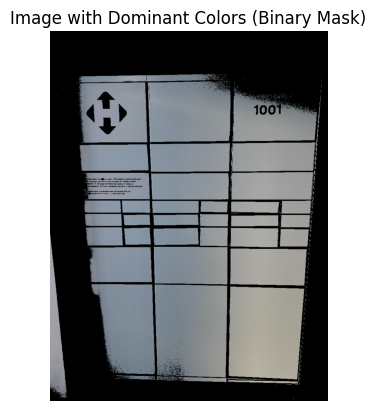

In [49]:
# Convert the list of LAB color values to a NumPy array
colors_array_lab = np.array(colors)

# Find the dominant color
dominant_color = np.mean(colors_array_lab, axis=0)

# Create a binary mask for non-dominant colors
tolerance = 30  # Tolerance for color difference
binary_mask = np.all(np.abs(lab_image - dominant_color) < tolerance, axis=-1)

# Apply the binary mask to the original image
result_image = image.copy()
result_image[~binary_mask] = [0, 0, 0]  # Set non-dominant colors to black

# Display the result
plt.imshow(result_image)
plt.title('Image with Dominant Colors (Binary Mask)')
plt.axis('off')
plt.show()

C:\Users\Tymof\AppData\Local\Temp\ipykernel_7336\456947848.py:9: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(cv2.boxPoints(min_area_rect))


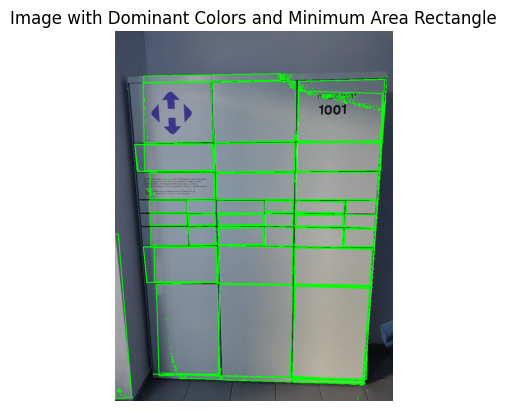

In [50]:
# Find contours in the binary mask
contours, hierarchy = cv2.findContours(binary_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find the minimum area rectangle for each contour
for contour in contours:
    min_area_rect = cv2.minAreaRect(contour)

    # Convert the rectangle parameters to integers
    box = np.int0(cv2.boxPoints(min_area_rect))

    # Draw the rectangle on the original image
    cv2.drawContours(image, [box], 0, (0, 255, 0), 2)

# Display the result
plt.imshow(image)
plt.title('Image with Dominant Colors and Minimum Area Rectangle')
plt.axis('off')
plt.show()


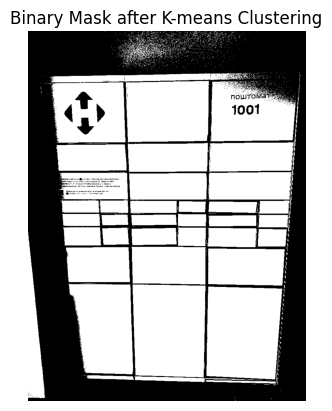

In [51]:


# Create binary masks for each rectangle based on dominant color ranges
binary_masks = []
for color_lab in colors_array_lab:
    lower_bound = np.maximum(color_lab - 20, [0, 0, 0])
    upper_bound = np.minimum(color_lab + 20, [255, 255, 255])
    binary_mask = cv2.inRange(lab_image, lower_bound, upper_bound)
    binary_masks.append(binary_mask)

# Combine binary masks into one
final_binary_mask = sum(binary_masks)

# Apply k-means clustering to the binary mask
num_clusters = 2  # You can adjust the number of clusters
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
_, labels, centers = cv2.kmeans(final_binary_mask.flatten().astype(np.float32).reshape(-1, 1), num_clusters, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# Find the label with the most pixels
dominant_label = np.argmax(np.bincount(labels.flatten()))

# Create a binary mask for the dominant cluster
cluster_mask = (labels == dominant_label).reshape(final_binary_mask.shape)

# Display the result
plt.imshow(cluster_mask, cmap='gray')
plt.title('Binary Mask after K-means Clustering')
plt.axis('off')
plt.show()


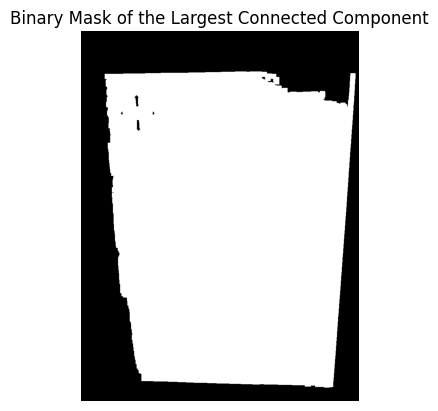

In [52]:


# Create a binary mask for non-dominant colors
tolerance = 30  # Tolerance for color difference
binary_mask = np.all(np.abs(lab_image - dominant_color) < tolerance, axis=-1)

# Apply morphological dilation to connect nearby regions
kernel = np.ones((15, 15), np.uint8)  # Adjust the kernel size as needed
connected_mask = cv2.dilate(binary_mask.astype(np.uint8), kernel, iterations=1)

# Use connected components to label objects in the connected mask
_, labels, stats, _ = cv2.connectedComponentsWithStats(connected_mask)

# Find the label of the largest connected component
largest_component_label = np.argmax(stats[1:, cv2.CC_STAT_AREA]) + 1

# Create a binary mask for the largest connected component
largest_component_mask = (labels == largest_component_label).astype(np.uint8)

# Display the result binary mask
plt.imshow(largest_component_mask, cmap='gray')
plt.title('Binary Mask of the Largest Connected Component')
plt.axis('off')
plt.show()


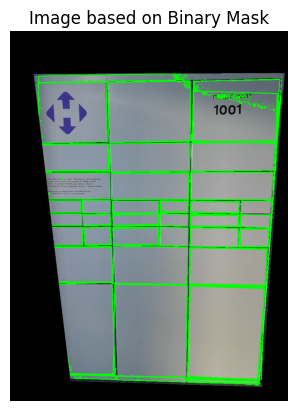

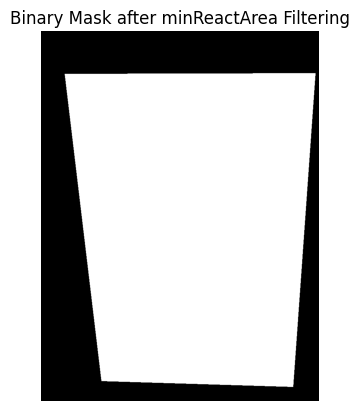

In [53]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def minReactArea(contour):
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    return cv2.contourArea(contour) / cv2.contourArea(box)


# Create a binary mask for non-dominant colors
tolerance = 30  # Tolerance for color difference
binary_mask = np.all(np.abs(lab_image - dominant_color) < tolerance, axis=-1)

# Apply morphological dilation to connect nearby regions
kernel = np.ones((15, 15), np.uint8)  # Adjust the kernel size as needed
connected_mask = cv2.dilate(binary_mask.astype(np.uint8), kernel, iterations=1)

# Use connected components to label objects in the connected mask
_, labels, stats, _ = cv2.connectedComponentsWithStats(connected_mask)

# Find the label of the largest connected component
largest_component_label = np.argmax(stats[1:, cv2.CC_STAT_AREA]) + 1

# Create a binary mask for the largest connected component
largest_component_mask = (labels == largest_component_label).astype(np.uint8)

# Find contours in the binary mask
contours, _ = cv2.findContours(largest_component_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter contours based on minReactArea
min_react_area_threshold = 0.1  # Adjust this value based on your requirements
filtered_contours = [cv2.convexHull(cv2.approxPolyDP(contour, 0.02 * cv2.arcLength(contour, True), True)) for contour in contours if minReactArea(contour) > min_react_area_threshold]

# Create a binary mask for the filtered contours
filtered_mask = np.zeros_like(largest_component_mask)
cv2.drawContours(filtered_mask, filtered_contours, -1, 1, thickness=cv2.FILLED)

# Apply the binary mask to the original image
result_image = image.copy()
result_image[filtered_mask == 0] = [0, 0, 0]  # Set pixels outside the mask to black

# Display the result image
plt.imshow(result_image)
plt.title('Image based on Binary Mask')
plt.axis('off')
plt.show()



# Display the result binary mask
plt.imshow(filtered_mask, cmap='gray')
plt.title('Binary Mask after minReactArea Filtering')
plt.axis('off')
plt.show()

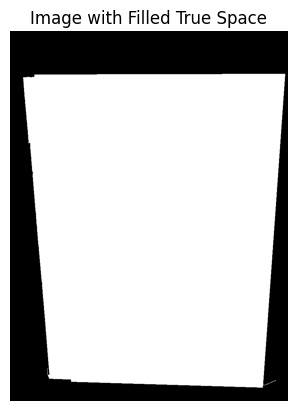

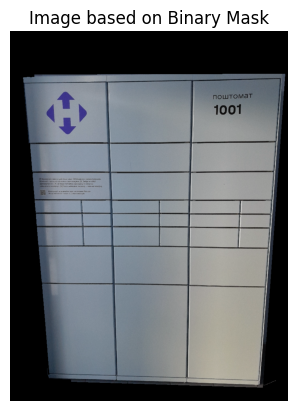

In [54]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load the image 
image = cv2.imread(img_location) 

# Convert to grayscale 
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 


# Blur the image 
blurred = cv2.GaussianBlur(gray, (5, 5), 0) 

# Detect edges 
edges = cv2.Canny(blurred, 50, 150) 

# Find contours 
contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 

# Draw all contours on a blank canvas
canvas = np.zeros_like(image)
cv2.drawContours(canvas, contours, -1, (0, 255, 0), 2)

# Convert to binary mask based on edges
edge_mask = np.zeros_like(gray)
cv2.drawContours(edge_mask, contours, -1, 1, thickness=cv2.FILLED)

# Combine the false space mask with the existing filtered mask
extended_mask = np.logical_or(filtered_mask, edge_mask)

# Apply the extended mask to the original image
result_image_extended = image.copy()
result_image_extended[extended_mask == 0] = [0, 0, 0]  # Set pixels outside the mask to black

# Fill the quadrilaterals in the extended mask with binary true values
# Find contours in the extended mask
contours, _ = cv2.findContours(extended_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_quadrilateral_mask_closed = None
# Filter contours based on the number of vertices (4 vertices for a quadrilateral)
quadrilaterals = [contour for contour in contours if len(cv2.approxPolyDP(contour, 0.02 * cv2.arcLength(contour, True), True)) == 4]
if len(quadrilaterals)==1:
    largest_quadrilateral = max(quadrilaterals, key=cv2.contourArea)
    largest_quadrilateral_mask = np.zeros_like(extended_mask, dtype=np.uint8)
    cv2.drawContours(largest_quadrilateral_mask, [largest_quadrilateral], -1, 1, thickness=cv2.FILLED)
    kernel_close = np.ones((60, 60), np.uint8)  # Adjust the kernel size for closing
    largest_quadrilateral_mask_closed = cv2.morphologyEx(largest_quadrilateral_mask, cv2.MORPH_CLOSE, kernel_close)
    result_image_filled_true_space = image.copy()
    result_image_filled_true_space[largest_quadrilateral_mask_closed == 0] = [0, 0, 0]  # Set pixels outside the mask to black
    contours, _ = cv2.findContours(result_image_filled_true_space.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
else:
    while(len(quadrilaterals)!=1):
        quadrilaterals = [contour for contour in contours if len(cv2.approxPolyDP(contour, 0.02 * cv2.arcLength(contour, True), True)) == 4]
        largest_quadrilateral = max(quadrilaterals, key=cv2.contourArea)
        largest_quadrilateral_mask = np.zeros_like(extended_mask, dtype=np.uint8)
        cv2.drawContours(largest_quadrilateral_mask, [largest_quadrilateral], -1, 1, thickness=cv2.FILLED)
        kernel_close = np.ones((4, 4), np.uint8)  # Adjust the kernel size for closing.
        # ADD IF STATEMENT NOTHING CHANGES ADD KERNEL SIZE
        largest_quadrilateral_mask_closed = cv2.morphologyEx(largest_quadrilateral_mask, cv2.MORPH_CLOSE, kernel_close)
        contours, _ = cv2.findContours(largest_quadrilateral_mask_closed.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


plt.imshow(largest_quadrilateral_mask_closed, cmap='gray')
plt.title('Image with Filled True Space')
plt.axis('off')
plt.show()

# Apply the binary mask to the original image
result_image = image.copy()
result_image[largest_quadrilateral_mask_closed == 0] = [0, 0, 0]  # Set pixels outside the mask to black

# Display the result image
plt.imshow(result_image)
plt.title('Image based on Binary Mask')
plt.axis('off')
plt.show()



In [55]:
recs = os.system(f'python ./models/lcnn/demo.py -d 0 ./models/lcnn/config/wireframe.yaml "C:/Users/Tymof/OneDrive/Desktop/education/Practice/Meduzzen_Intership/ML_NovaPoshta_CV/models/lcnn/190418-201834-f8934c6-lr4d10-312k.pth" "C:/Users/Tymof/OneDrive/Desktop/education/Practice/Meduzzen_Intership/ML_NovaPoshta_CV/data/images_data/1002(2023-06-29T11_47_18).jpg"  ')